Student Details

Name: Cathal Cronin

ID: 10131531

# Lab 4: Comparison of Classifiers

This notebook demonstrates how to choose the best out of a few alternative classification models by applying cross-validation and comparing the accuracy of prediction, the F1-scores and the ROC curves of the classification models.

Here we use a _modified version_ of the __seeds data set__ (see https://archive.ics.uci.edu/ml/datasets/seeds), which is one of the public UCI data sets. Each example is a seed described by a few numerical attributes. The target variable for classification (in this example) is the type of the seed, which can be either 1 or 0. Class 1 are the seeds of a particular type that, we can assume, is important to learn to predict correctly, while class 0 are all other seeds.

In this example, we use 5-fold cross-validation. Empirical evidence suggests that 10 folds are probably the best choice for cross-validation, i.e. 10-fold cross-validation. However, since this data set is relatively small, and 1/10 of it is only 21 examples, it is sensible to use larger folds for testing. Thus, we demonstrate the comparison of classifiers with 5-fold cross-validation.

The code in this notebook was originally inspired by the example at https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html.

## A. Preparation

### Import Python modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from itertools import cycle

from sklearn import preprocessing #needed for scaling attributes to the nterval [0,1]
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve

from scipy import interp

### Import evaluation and plotting functions

In [2]:
%run ./Lab4_Functions.ipynb

### Load and prepare the dataset for training and evaluating a classifier
Feel free to apply any other pre-processing technique at this point.

In [3]:
lab4_df = pd.read_csv("./seeds_dataset_binary.csv")
lab4_df.describe()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071,0.333333
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480,0.472531
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,0.000000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,0.000000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,0.000000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,1.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,1.000000


In [4]:
# target attribute
target = lab4_df['type']

# predictor attributes
predictors = lab4_df.drop('type', axis=1).values

# scale all predictor values to the range [0, 1]
# note the target attribute 'type' is already binary
min_max_scaler = preprocessing.MinMaxScaler()
predictors = min_max_scaler.fit_transform(predictors)

### Prepare an array of 100 equally spaced false-positive-rate values between 0 and 1
To be used as an x-axis in ROC curve plots.

In [5]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

## B. Evaluation and Comparison of Classifiers

### Train a Probablistic SVM Classifier

In [6]:
# Create an SVM classifier object as a probabilistic classifier with default parameters
SVM_classifier = svm.SVC(probability=True)

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_SVM, f1_scores_SVM, tprs_SVM, aucs_SVM, _recalls_SVM, _precisions_SVM = evaluate_classifier(folds=5, 
                                                                        p=predictors, t=target, 
                                                                        classifier=SVM_classifier, 
                                                                        mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

/Users/cathalc/.pyenv/versions/3.5.6/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/cathalc/.pyenv/versions/3.5.6/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/cathalc/.pyenv/versions/3.5.6/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/cathal

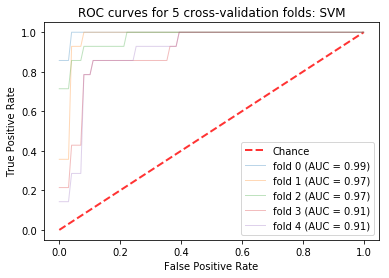

In [7]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_SVM, aucs_SVM, 'SVM')

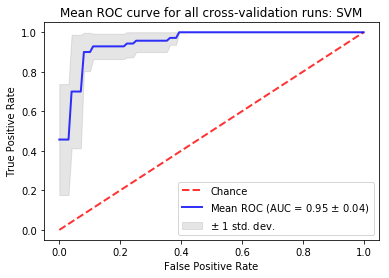

In [8]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_SVM, aucs_SVM, 'SVM')

### Train a Naive Bayes Classifier

In [9]:
# Create a Naive Bayes classifier object with default parameters (note: Naive Bayes is a probabilistic classifier by default)
NB_classifier = GaussianNB()

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_NB, f1_scores_NB, tprs_NB, aucs_NB, _recalls_NB, _precisions_NB = evaluate_classifier(folds=5, 
                                                                    p=predictors, t=target, 
                                                                    classifier=NB_classifier, 
                                                                    mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

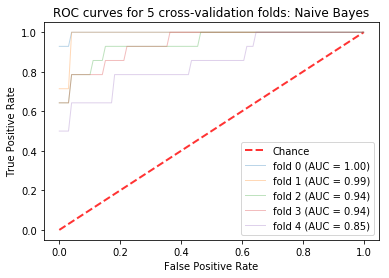

In [10]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_NB, aucs_NB, 'Naive Bayes')

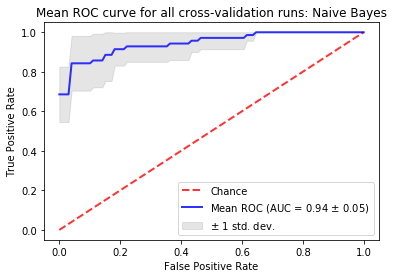

In [11]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_NB, aucs_NB, 'Naive Bayes')

### Compare All Trained Classifiers

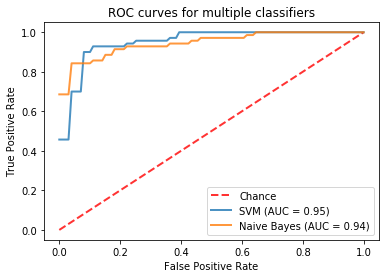

In [12]:
plot_roc_multiple_classifiers(mean_fpr, 
                              np.stack((np.mean(tprs_SVM, axis=0), np.mean(tprs_NB, axis=0))), 
                              np.array([np.mean(aucs_SVM), np.mean(aucs_NB)]), 
                              np.array(['SVM', 'Naive Bayes']))

In [13]:
# Compare the statistics of the accuracies across all cross-validation folds
accuracies_df = pd.DataFrame(data={'SVM' : accuracies_SVM, 'Naive Bayes' : accuracies_NB})

In [14]:
accuracies_df.describe()

,Naive Bayes,SVM
count,5.000000,5.000000
mean,0.880952,0.876190
std,0.078967,0.045799
min,0.761905,0.809524
25%,0.857143,0.857143
50%,0.880952,0.880952
75%,0.952381,0.904762
max,0.952381,0.928571


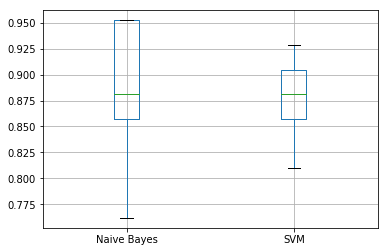

In [15]:
accuracies_df.boxplot()

In [16]:
# Compare the statistics of the F1-scores across all cross-validation folds
f1_scores_df = pd.DataFrame(data={'SVM' : f1_scores_SVM, 'Naive Bayes' : f1_scores_NB})

In [17]:
f1_scores_df.describe()

,Naive Bayes,SVM
count,5.000000,5.000000
mean,0.824418,0.804812
std,0.116353,0.056227
min,0.642857,0.750000
25%,0.800000,0.769231
50%,0.827586,0.782609
75%,0.923077,0.833333
max,0.928571,0.888889


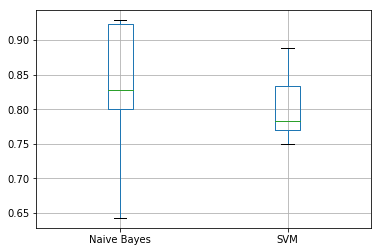

In [18]:
f1_scores_df.boxplot()

#### Conclusion

In this example, both the SVM and the Naive Bayes classifiers have mean accuracy approximately 88%, which is quite high. The ROC curves do not suggest a clear winner, although it can be noted that Naive Bayes can achieve TPR above 80% for a lower FPR than SVM. On the other hand, the accuracy of the five folds of Naive Bayes show higher variance than the accuracy of the five folds of SVM, and low variance is desirable. Still, the lowest accuracy of Naive Bayes is above 75% which is not bad. Similar observation can be made about the F1 score. Naive Bayes has a higher mean F1 score but also higher variance. Since both SVM and Naive Bayes have high mean accuracy, high mean F1 score and a very similar AUC, while SVM appears to have visibly lower variance than Naive Bayes, we can conclude that perhaps SVM is a safer choice for a best model. 

It will be interesting to plot precision and recall for a more detailed comparison. Since the two classes are not well balanced (1/3 of the examples are in class 1), a precision-recall curve a more detailed study of the precision and recall can provide better information than the ROC curves for picking the best model.

## C. FInal Model

Assuming SVM was chosen, now we can train a final (to be potentially deployed) SVM model with the whole dataset:

In [19]:
model = NB_classifier.fit(predictors, target)

Use the model to predict the type of three new seeds:

In [20]:
new_seeds = np.array([[0.4,0.5,0.6,0.5,0.5,0.2,0.3], [0.0,1.0,0.0,1.0,0.5,0.5,0.2], [0.2,0.2,0.2,1.0,0.2,0.2,0.2]])

In [21]:
# Probabilistic prediction
np.round(model.predict_proba(new_seeds), 2)
# Note: 
#   - the first column are the probabilities for the three new seeds to belong to class 0
#   - the second column are the probabilities for the three new seeds to belong to class 1

array([[0.01, 0.99],
       [1.  , 0.  ],
       [1.  , 0.  ]])

In [22]:
# Exact prediction
model.predict(new_seeds)

array([1, 0, 0])

# Task 1
  * Watch the video playlist CS5062-E-tivity4 (ca. 40 min).
  * Read the article How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python.
  * Use the following files (available in the GitLab repository):
    * **Lab 4 - Comparison of Classifiers - Main.ipynb** - This is the main example notebook to follow these two weeks. It contains code for training and evaluating SVM and Naïve Bayes classifiers.
    * **Lab4_Functions.ipynb** - This notebook contains some functions used in the man example notebook. They have been put in a separate file to keep the main notebook easier to follow.
    * **seeds_dataset_binary.csv** - This is the data set used in the main example notebook.
    * **data set loans_et4.csv**. This is a modified version of the loans data set with 1 for Loan_Status = Yes and 0 for Loan_Status = No. You are asked to work with this data set in Tasks 1-3.
 * Replicate the classifier training and evaluation demonstrated in the main example notebook **Lab 4 - Comparison of Classifiers - Main.ipynb** but with the data set **loans_et4.csv** and target attribute **Loan_Status**. Then train another probabilistic classifier with loans_et4.csv add compare it to both SVM and Naïve Bayes. For this third classifier, you can pick any scikit-learn probabilistic classification algorithm apart from SVM and Naive Nayes. Summarise your conclusions (max 150 words in a markdown cell).
 


In [23]:
loans_df = pd.read_csv("./loans_et4.csv")
loans_df.describe()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,0.820833,0.647917,0.777083,0.797917,0.137500,5364.231250,1581.093583,144.735417,342.050000,0.854167,1.022917,0.691667
std,0.383892,0.478118,1.020815,0.401973,0.344734,5668.251251,2617.692267,80.508164,65.212401,0.353307,0.776411,0.462287
min,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,9.000000,36.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,0.000000,2898.750000,0.000000,100.000000,360.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,1.000000,0.000000,3859.000000,1084.500000,128.000000,360.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,2.000000,1.000000,0.000000,5852.500000,2253.250000,170.000000,360.000000,1.000000,2.000000,1.000000
max,1.000000,1.000000,3.000000,1.000000,1.000000,81000.000000,33837.000000,600.000000,480.000000,1.000000,2.000000,1.000000


In [24]:
# target attribute
target = loans_df['Loan_Status']

# predictor attributes
predictors = loans_df.drop('Loan_Status', axis=1).values

# scale all predictor values to the range [0, 1]
# note the target attribute 'type' is already binary
min_max_scaler = preprocessing.MinMaxScaler()
predictors = min_max_scaler.fit_transform(predictors)

In [25]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [26]:
# Create an SVM classifier object as a probabilistic classifier with default parameters
SVM_classifier = svm.SVC(probability=True)

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_SVM, f1_scores_SVM, tprs_SVM, aucs_SVM, _recalls_SVM, _precisions_SVM = evaluate_classifier(folds=5, 
                                                                        p=predictors, t=target, 
                                                                        classifier=SVM_classifier, 
                                                                        mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold


/Users/cathalc/.pyenv/versions/3.5.6/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/cathalc/.pyenv/versions/3.5.6/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/cathalc/.pyenv/versions/3.5.6/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/cathal

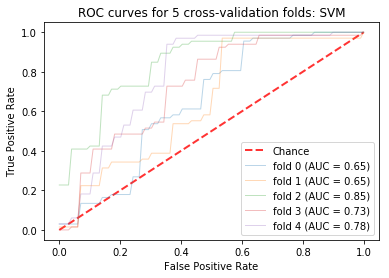

In [27]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_SVM, aucs_SVM, 'SVM')

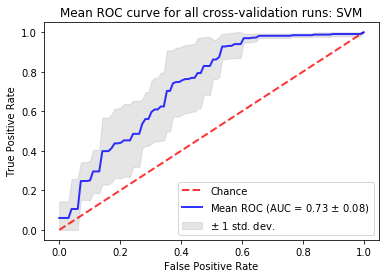

In [28]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_SVM, aucs_SVM, 'SVM')

In [29]:
# Create a Naive Bayes classifier object with default parameters (note: Naive Bayes is a probabilistic classifier by default)
NB_classifier = GaussianNB()

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_NB, f1_scores_NB, tprs_NB, aucs_NB, _recalls_NB, _precisions_NB = evaluate_classifier(folds=5, 
                                                                    p=predictors, t=target, 
                                                                    classifier=NB_classifier, 
                                                                    mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold


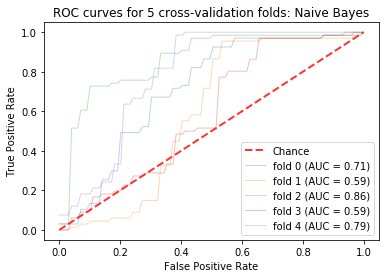

In [30]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_NB, aucs_NB, 'Naive Bayes')

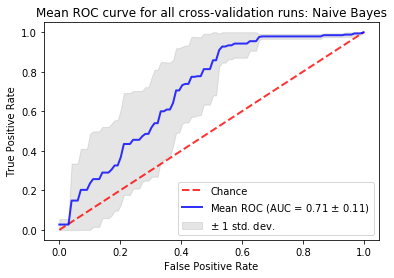

In [31]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_NB, aucs_NB, 'Naive Bayes')

In [32]:
# Use a different classifier from sci-kit learn. Compare and contrast this later with the other 2 classifiers

In [33]:
from sklearn.ensemble import RandomForestClassifier
RF_classifier = RandomForestClassifier(n_estimators=100, max_depth=4,
                             random_state=0)

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_RF, f1_scores_RF, tprs_RF, aucs_RF, _recalls_RF, _precisions_RF = evaluate_classifier(folds=5, 
                                                                    p=predictors, t=target, 
                                                                    classifier=RF_classifier, 
                                                                    mean_fpr=mean_fpr)



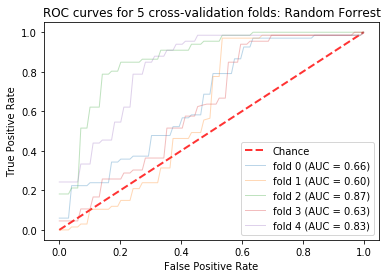

In [34]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_RF, aucs_RF, 'Random Forrest')

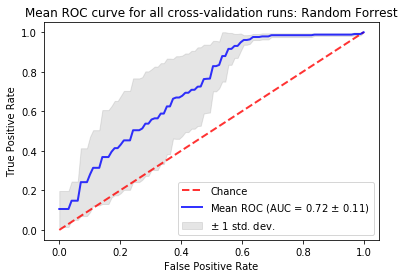

In [35]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_RF, aucs_RF, 'Random Forrest')

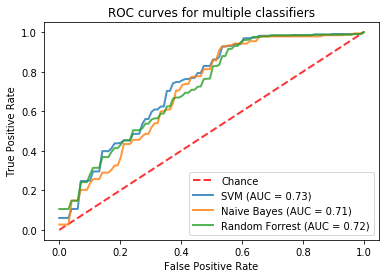

In [36]:
# Compare the different classifiers 
plot_roc_multiple_classifiers(mean_fpr, 
                              np.stack((np.mean(tprs_SVM, axis=0), np.mean(tprs_NB, axis=0), np.mean(tprs_RF, axis=0))), 
                              np.array([np.mean(aucs_SVM), np.mean(aucs_NB), np.mean(aucs_RF)]), 
                              np.array(['SVM', 'Naive Bayes', 'Random Forrest']))

In [37]:
# Compare the statistics of the accuracies across all cross-validation folds
accuracies_df = pd.DataFrame(data={'SVM' : accuracies_SVM, 'Naive Bayes' : accuracies_NB, 'Random Forest' : accuracies_RF})

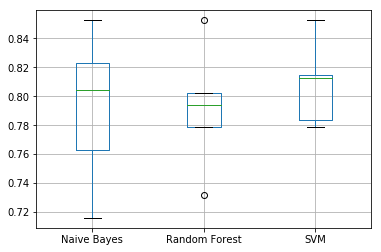

In [38]:
accuracies_df.boxplot()

In [39]:
accuracies_df.describe()

,Naive Bayes,Random Forest,SVM
count,5.000000,5.000000,5.000000
mean,0.791670,0.791887,0.808403
std,0.053465,0.043464,0.029567
min,0.715789,0.731959,0.778947
25%,0.762887,0.778947,0.783505
50%,0.804124,0.793814,0.812500
75%,0.822917,0.802083,0.814433
max,0.852632,0.852632,0.852632


In [40]:
# Compare the statistics of the F1-scores across all cross-validation folds
f1_scores_df = pd.DataFrame(data={'SVM' : f1_scores_SVM, 'Naive Bayes' : f1_scores_NB, 'Random Forest' : f1_scores_RF})

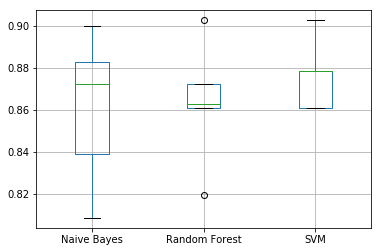

In [41]:
f1_scores_df.boxplot()

### Conclusions

- All 3 classifiers perform quite similarly on the loans dataset.
- The ROC curves are very similar to one another. Doesn't distingush a clear winner.
    - The area under the curve (AUC) can be used as a summary of the model skill.
- Naive Bayes and Random Forrest performed to the same degree of accurary as can be seen from the mean value and the SVM just slightly outperformed both.
- The variance of the naive bayes classifier is higher and we can see this on the box plot above.
- In conclusion it looks like the SVM classifier is the one to go with so far!

# Task 2
  * Modify the code in both **Lab 4 - Comparison of Classifiers.ipynb** and **Lab4_Functions.ipynb** to boxplot precision and recall for the classifiers trained with loans_et4.csv. 
  * Update your conclusions from Task 1 after evaluating precision and recall.

In [42]:
# Compare the statistics of the precision across all cross-validation folds
precision_df = pd.DataFrame(data={'SVM' : _precisions_SVM   , 'Naive Bayes' : _precisions_NB    , 'Random Forrest' : _precisions_RF})
precision_df.describe()

,Naive Bayes,Random Forrest,SVM
count,5.000000,5.000000,5.000000
mean,0.800727,0.788975,0.793400
std,0.033546,0.028196,0.026854
min,0.760000,0.764706,0.764706
25%,0.789474,0.766234,0.773810
50%,0.792683,0.783133,0.792683
75%,0.810127,0.797468,0.802469
max,0.851351,0.833333,0.833333


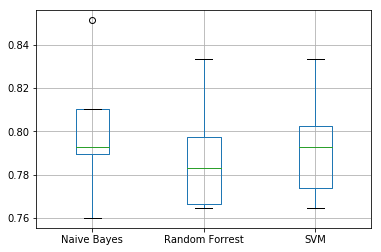

In [43]:
precision_df.boxplot()

In [44]:
# Compare the statistics of the recalls across all cross-validation folds
recalls_df = pd.DataFrame(data={'SVM' : _recalls_SVM   , 'Naive Bayes' : _recalls_NB    , 'Random Forrest' : _recalls_RF})
recalls_df.describe()

,Naive Bayes,Random Forrest,SVM
count,5.000000,5.000000,5.000000
mean,0.930710,0.955088,0.978969
std,0.048427,0.045893,0.008051
min,0.863636,0.880597,0.970149
25%,0.895522,0.940299,0.970149
50%,0.954545,0.984848,0.984848
75%,0.969697,0.984848,0.984848
max,0.970149,0.984848,0.984848


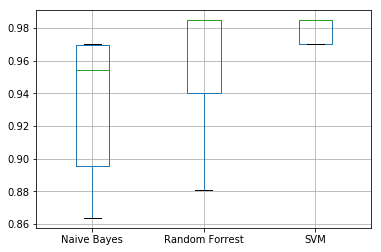

In [45]:
recalls_df.boxplot()

In [46]:
# conclusions

- Precision is used to see how good a model is at predicting the positive class. 
- Recall is useful in cases where there is an imbalance in the observations between the two classes

Looking at the above tables and plots. The precission mean values are very very close. 

- 0.800727 for Naive Bayes
- 0.788975 for Random Forrest
- 0.793400 for SVM

Again the Naive bayes has a higher std deviation than the other 2 classifiers. Indicating that Random Forrest and SVM give a tighter bound for accurary.

Looking at the recall however. SVM has a far higher mean value of 0.97 compared to 0.93 for naive bayes. And the std deviation for SVM is lowest compared to both. 

Although they are similar in performence the SVM seems to be the better one.

Ref: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

# Task 3

  * Pick a winner among the classifiers you have trained with loans_et4.csv. 
  * Assume that it is important to minimise the false positives (i.e., Loan_Status predicted to be 1 wrongly). 
  * Look up the training parameters for this classifier on the scikit-learn website. 
    * For example, SVM has more than 10 parameters (see https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). 
    * Experiment with the parameters and see if you can improve the model in terms of accuracy, precision, recall and AUC.
    * You do not have to build a better model but to show that you have explored some of its training parameters. 
    * Summarise your experience with exploring the parameters (max 150 words in a markdown cell).

REF: https://medium.com/@aneesha/svm-parameter-tuning-in-scikit-learn-using-gridsearchcv-2413c02125a0
        

In [47]:
import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

def make_svc_grid_search(nfolds, scoring):
    probas = [True]    
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1, 2]
    kernels = ['linear', 'poly', 'rbf']
    degrees = [2, 3, 4]
    class_weight = [None, {0: 1 , 1: 3}] 
    param_grid = {'C': Cs,
                  'gamma' : gammas,
                  'kernel' : kernels,
                  'degree': degrees,
                  'probability' : probas,
                  'class_weight' : class_weight }
    
    svm_classifier = svm.SVC()
    
    return get_grid_search(svm_classifier, param_grid, nfolds, scoring)

def get_grid_search(estimator, param_grid, nfolds, scoring):
    if scoring =='default':
        return GridSearchCV(estimator, param_grid, cv=nfolds)
    else:
        return GridSearchCV(estimator, param_grid, cv=nfolds, scoring=scoring)

def run_gridsearch(grid_search, X, y):
    start = time.time()
    print("Running...")

    grid_search.fit(X, y)
    grid_search.best_params_
    
    end = time.time()
    print("best score : %s" % grid_search.best_score_ )
    return grid_search.best_params_, grid_search.best_estimator_, grid_search.best_score_


In [48]:
# Use the default scoring in SVM
gridsearch_default_SVC_params, gridsearch_default_SVC, gridsearch_default_SVC_score = run_gridsearch(make_svc_grid_search(10, 'default'), predictors, target)

Running...
best score : 0.8083333333333333


/Users/cathalc/.pyenv/versions/3.5.6/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [49]:
# Use roc_auc scoring in SVM
best_SVC_params, best_SVC, best_SVC_score = run_gridsearch(make_svc_grid_search(10, 'roc_auc'), predictors, target)

Running...
best score : 0.7586822001527884


/Users/cathalc/.pyenv/versions/3.5.6/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [50]:
def compare_classifiers(clfs, titles):
    
    for index, clf in enumerate(clfs):
        plt.figure(figsize=(25, 5)) 
        p = 141    
        clf_name = titles[index]

        accuracies, f1_scores, tprs, aucs, _precisions, _recalls = evaluate_classifier(folds=5, 
                                                                            p=predictors, t=target, 
                                                                            classifier=clf, 
                                                                            mean_fpr=mean_fpr)
        
        plt.subplot(p, frameon=False)
        plot_roc_cv_folds(mean_fpr, tprs, aucs, clf_name, show=False)

        p += 1
        plt.subplot(p, frameon=False)
        plot_roc_mean(mean_fpr, tprs, aucs, clf_name, show=False)

        plt.tight_layout() 
        plt.show()

/Users/cathalc/.pyenv/versions/3.5.6/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/cathalc/.pyenv/versions/3.5.6/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/cathalc/.pyenv/versions/3.5.6/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/cathal

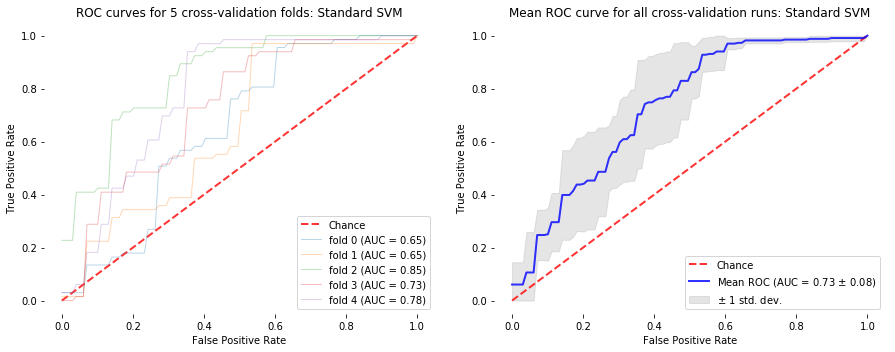

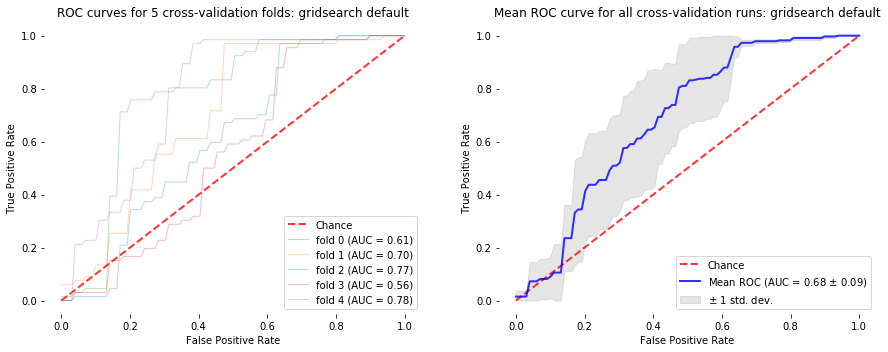

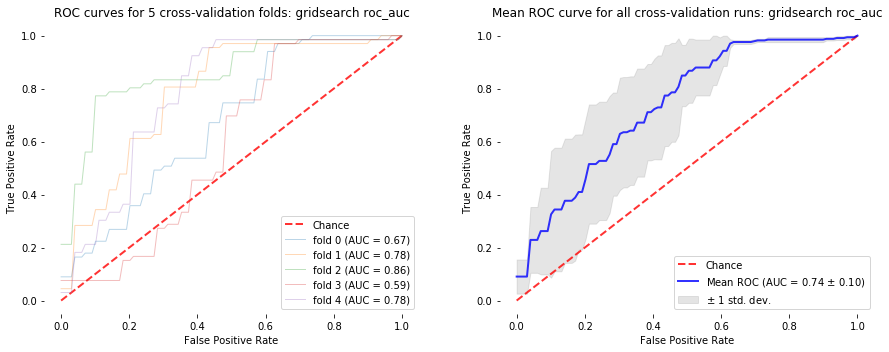

In [51]:
# Using classifiers with default values
clfs = [SVM_classifier, gridsearch_default_SVC, best_SVC]
titles = ['Standard SVM', 'gridsearch default', 'gridsearch roc_auc']
compare_classifiers(clfs, titles)


- Using the gridsearch we can change the scoring to a different type. The list to choose from is in the link below.

- We can see an improvement when using applying one of the alternative scoring parameters. 'roc_auc' scoring. Granted when compared to the basic SVM model run it didn't out perform it by a big margin it was only a 1% improvement. But the default scoring of gridsearch compared to the 'roc_auc' scoring lead to a 6% improvement so that's a good improvement and shows how parameter tuning can affect model performence!

Ref: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
https://medium.com/@aneesha/svm-parameter-tuning-in-scikit-learn-using-gridsearchcv-2413c02125a0

